# 데이터 불러오기 및 전처리

**1. 라이브러리 Import**

In [1]:
# !pip install opencv-python
# !pip install keras
# !pip install tensorflow
# !pip install tensorflow --use-feature=2020-resolver
# !pip install sklearn
# !pip install seaborn

In [2]:
%matplotlib inline
import keras
import tensorflow
import os, cv2, PIL, gc, psutil
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.models import Model, Sequential

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Dropout, Flatten, Dense

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.activations import softmax, relu

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications

**2. 이미지를 불러와서 RGB형태의 값을 가진 np배열로 변환**

In [3]:
from PIL import Image #이미지 분석 및 처리를 쉽게 할 수 있는 라이브러리
import glob, numpy as np

data_dir = "./data/train"
categories = ["melanoma", "nevus", "seborrheic_keratosis"] #흑색종, 점, 검버섯
n_classes = len(categories) #각 카테고리별 이미지 개수

#이미지크기
image_w = 224
image_h = 224

X = []
y = []

for idx, category in enumerate(categories):

    #원-핫 인코딩(One-Hot Encoding)
    label = [0 for i in range(n_classes)]
    label[idx] = 1
    image_dir = data_dir + "/" + category
    
    files = glob.glob(image_dir+"/*.jpg") #jpg형태의 이미지id를 리스트형태로 반환.
    print(category, "파일 개수 :", len(files))
    
    #각 이미지를 RGB값으로 변환하고 크기도 변환한 후, np배열로 저장.
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

X = np.array(X) #입력 이미지
y = np.array(y) #label

print("total:", len(y)) #총 파일개수

melanoma 파일 개수 : 1346
nevus 파일 개수 : 784
seborrheic_keratosis 파일 개수 : 789
total: 2919


**3. 데이터분할**

In [4]:
from sklearn.model_selection import train_test_split

#훈련 데이터와 검증할 데이터 분할
from keras.utils import np_utils
trainx, valx, trainy, valy = train_test_split(X, y, test_size=0.03,random_state=41, shuffle=True)

훈련 데이터 : 97% 검증 데이터 : 3%의 비율로 전체 데이터를 랜덤하게 나눔.

In [5]:
print("X_train shape", trainx.shape)
print("y_train shape", trainy.shape)
print("X_val shape", valx.shape)
print("y_val shape", valy.shape)

len(trainx), len(valx) #훈련데이터, 검증데이터 개수

X_train shape (2831, 224, 224, 3)
y_train shape (2831, 3)
X_val shape (88, 224, 224, 3)
y_val shape (88, 3)


(2831, 88)

배열의 형태 : (이미지개수, 이미지크기(224 * 224), 이미지 채널의 수(RGB) )

In [6]:
#정규화
trainx = trainx.astype(float) / 255
valx = valx.astype(float) / 255

# AI 모델링

CNN구조를 가진 ResNet50을 사용하여 흑색종과 점과 검버섯 판별.

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping

input_shape = (224,224,3) #입력 형태 정의(행,열,채널수)

epoch = 15
batch_size = 16


#모델 생성
#ResNet50 사용
base_model = ResNet50(include_top=False, input_shape= (224,224,3), weights = 'imagenet')

base_model.trainable = True
model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))

model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(learning_rate = 1e-5), 
              metrics=["accuracy"]) 

#모델 학습
#가장 높은 정확도를 가졌던 모델 저장
checkpoint = ModelCheckpoint('checkpoint.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max') 

#Overfitting을 방지하기 위해 loss가 지속되면 중지.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

#모델의 개선이 없을 경우 lr조정.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, #5
                                   verbose=1, mode='max', min_lr=0.00001)                                                        
callbacks_list = [checkpoint, early_stopping]


history = model.fit(trainx, trainy,
                    batch_size=batch_size, 
                    epochs=epoch,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/15
142/142 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7403
Epoch 00001: val_accuracy improved from -inf to 0.27690, saving model to checkpoint.h5


C:\Users\User\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


142/142 [==============================] - 1034s 7s/step - loss: 0.6623 - accuracy: 0.7403 - val_loss: 4.5310 - val_accuracy: 0.2769
Epoch 2/15
142/142 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8896
Epoch 00002: val_accuracy did not improve from 0.27690
142/142 [==============================] - 1098s 8s/step - loss: 0.2973 - accuracy: 0.8896 - val_loss: 3.9341 - val_accuracy: 0.2769
Epoch 3/15
142/142 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9443
Epoch 00003: val_accuracy did not improve from 0.27690
142/142 [==============================] - 1163s 8s/step - loss: 0.1733 - accuracy: 0.9443 - val_loss: 4.0922 - val_accuracy: 0.2769
Epoch 4/15
142/142 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9678
Epoch 00004: val_accuracy improved from 0.27690 to 0.27866, saving model to checkpoint.h5
142/142 [==============================] - 1229s 9s/step - loss: 0.1165 - accuracy: 0.9678 - val_loss: 6.9941 - v

# AI 모델 평가 및 분석

**가장 best의 모델의 정확도**

In [8]:
from tensorflow.python.keras.models import load_model

model = load_model('checkpoint.h5')

loss,acc = model.evaluate(valx, valy, verbose=1)
print("accuracy: ", str(np.round(acc,2)*100) + "%")

3/3 [==============================] - 11s 3s/step - loss: 0.2991 - accuracy: 0.9318
accuracy:  93.0%


**정확도, 손실 그래프**

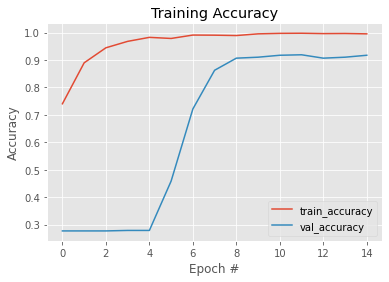

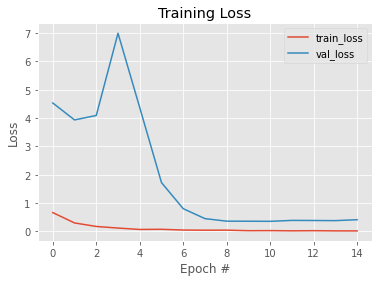

In [9]:
#Accuracy graph
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,15), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,15), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Loss graph
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,15), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,15), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

**각 이미지별로 실제값과 예측된 값 출력**

In [10]:
model = load_model('checkpoint.h5')

predictions = model.predict(valx) #검증데이터로 예측
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) #np배열 출력 형태 정의
cnt = 0
limit = 0.5 #각 label의 예측된 확률의 임계값


#실제 label과 예측된 label 출력
for prediction in predictions: #prediction : 각 label에 대한 확률을 나타낸 리스트
    print(cnt)
    
    if prediction[0] >= limit :
        print("Actual: " + categories[0] + " -> Predict: " + categories[valy[cnt].argmax()])
        
    if prediction[1] >= limit : 
        print("Actual: " + categories[1] + " -> Predict: " + categories[valy[cnt].argmax()])
        
    if prediction[2] >= limit : 
        print("Actual: "+ categories[2] + " -> Predict: " + categories[valy[cnt].argmax()])
        
    cnt += 1


0
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
1
Actual: melanoma -> Predict: melanoma
2
Actual: nevus -> Predict: nevus
3
Actual: melanoma -> Predict: melanoma
4
Actual: melanoma -> Predict: melanoma
5
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
6
Actual: melanoma -> Predict: melanoma
7
Actual: melanoma -> Predict: melanoma
8
Actual: melanoma -> Predict: melanoma
9
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
10
Actual: melanoma -> Predict: melanoma
11
Actual: melanoma -> Predict: melanoma
12
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
13
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
14
Actual: melanoma -> Predict: melanoma
15
Actual: melanoma -> Predict: melanoma
16
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
17
Actual: seborrheic_keratosis -> Predict: seborrheic_keratosis
18
Actual: melanoma -> Predict: melanoma
19
Actual: melanoma -> Predict: melanoma
20
Actual: seborrheic_kerato

**Confusion_matrix**

In [11]:
y_val_label = list(map(np.argmax, valy)) #검증할 데이터를 리스트로 변환한 값
y_pred_label = list(map(np.argmax, predictions)) #예측된 label을 리스트로 변환한 값

<AxesSubplot:>

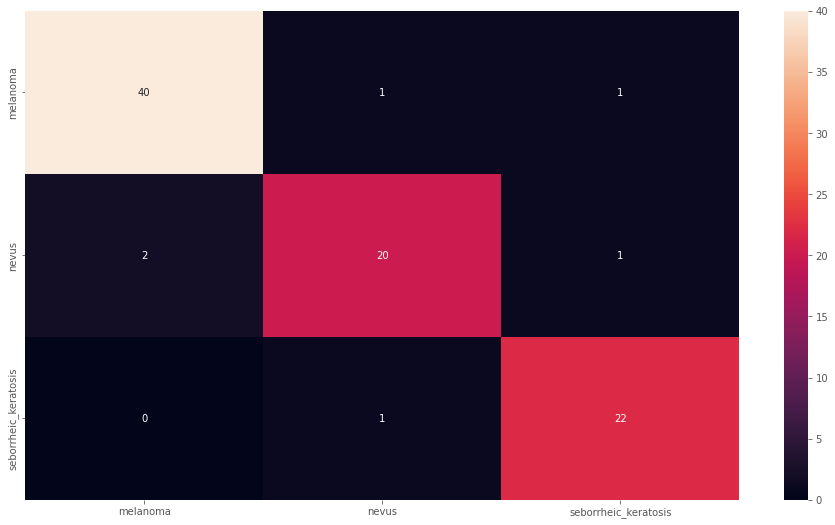

In [12]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16,9))

cm = confusion_matrix(y_val_label,y_pred_label)
sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = categories,yticklabels = categories)

**잘못 예측한 이미지들 확인**

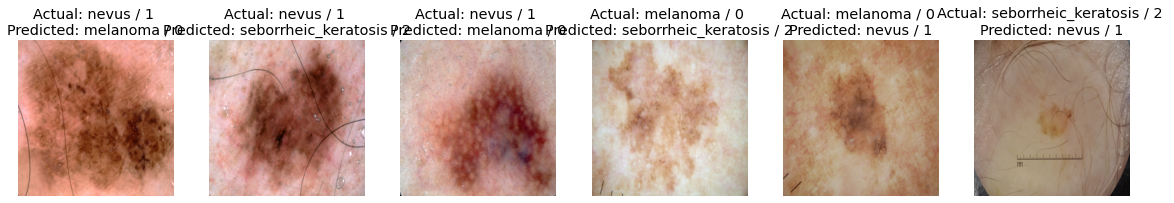

In [13]:
aaa = np.array(y_val_label) != np.array(y_pred_label)
not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
    plt.subplot(6,6,j); j+=1
    plt.imshow(valx[i],cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual: {} / {} \nPredicted: {} / {}'.format(categories[y_val_label[i]],
                                                            y_val_label[i],
                                                            categories[y_pred_label[i]],
                                                            y_pred_label[i]))

**정확도, 재현율, F1 score**

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(y_val_label, y_pred_label))
print(precision_score(y_val_label, y_pred_label, average=None))
print(recall_score(y_val_label, y_pred_label, average=None))
print(f1_score(y_val_label, y_pred_label, average=None))

0.9318181818181818
[0.952 0.909 0.917]
[0.952 0.870 0.957]
[0.952 0.889 0.936]
